In [1]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from hmmlearn import hmm

from warnings import filterwarnings

filterwarnings("ignore")

import pandas as pd
import numpy as np

from modules.data_fetcher import download_historical_data


In [44]:
symbol = "BTC-USDT"  # Best: BNB, BTC,

df_BTC = download_historical_data(symbol, "1hour").loc["2022-11-20":]
df_BTC.dropna(inplace=True)

df_BTC["Returns"] = df_BTC.Close.pct_change()
df_BTC["Log_Returns"] = np.log(df_BTC.Close).pct_change()
df_BTC.dropna(inplace=True)
print(df_BTC.shape)
df_BTC.head()

(2707, 9)


,Timestamp,Open,Close,High,Low,Amount,Volume,Returns,Log_Returns
Date,,,,,,,,,
2022-11-20 01:00:00,1.668902e+09,16700.5,16721.7,16736.4,16689.5,315.200337,5.269516e+06,0.001263,0.000130
2022-11-20 02:00:00,1.668906e+09,16721.7,16686.0,16749.1,16674.7,330.284788,5.521101e+06,-0.002135,-0.000220
2022-11-20 03:00:00,1.668910e+09,16686.0,16686.4,16707.2,16670.4,260.448188,4.347126e+06,0.000024,0.000002
2022-11-20 04:00:00,1.668913e+09,16686.4,16678.4,16696.9,16670.1,157.967725,2.635620e+06,-0.000479,-0.000049
2022-11-20 05:00:00,1.668917e+09,16678.5,16685.6,16695.7,16676.2,112.115207,1.870771e+06,0.000432,0.000044


In [33]:
model = MarkovRegression(
    df_BTC.Returns, k_regimes=2, trend="c", switching_variance=False, order=2
)
res_kns = model.fit()
res_kns.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                Returns   No. Observations:                 2707
Model:               MarkovRegression   Log Likelihood               10792.614
Date:                Sun, 12 Mar 2023   AIC                         -21575.229
Time:                        19:44:17   BIC                         -21545.711
Sample:                    11-20-2022   HQIC                        -21564.556
                         - 03-12-2023                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.175e-05      0.000      0.479      0.632      -0.000       0.000
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.457e-05      0.000      0.497      0.619      -0.000       0.000
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.016e-05   5.48e-07     36.790      0.000    1.91e-05    2.12e-05
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.5000        nan        nan        nan         nan         nan
p[1->0]        0.5000        nan        nan        nan         nan         nan
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 1.57e+16. Standard errors may be unstable.
"""

In [34]:
df_BTC["Low_regime_proba"] = tuple(res_kns.smoothed_marginal_probabilities[0])
df_BTC["High_regime_proba"] = tuple(res_kns.smoothed_marginal_probabilities[1])

df_BTC.loc[df_BTC["Low_regime_proba"] < df_BTC["High_regime_proba"], "Regime"] = 1
df_BTC.loc[df_BTC["Low_regime_proba"] > df_BTC["High_regime_proba"], "Regime"] = 2
df_BTC["Regime"] = df_BTC["Regime"].astype(int)

df_BTC.head()


,Timestamp,Open,Close,High,Low,Amount,Volume,Returns,Low_regime_proba,High_regime_proba,Regime
Date,,,,,,,,,,,
2022-11-20 01:00:00,1.668902e+09,16700.5,16721.7,16736.4,16689.5,315.200337,5.269516e+06,0.001263,0.499919,0.500081,1
2022-11-20 02:00:00,1.668906e+09,16721.7,16686.0,16749.1,16674.7,330.284788,5.521101e+06,-0.002135,0.500038,0.499962,2
2022-11-20 03:00:00,1.668910e+09,16686.0,16686.4,16707.2,16670.4,260.448188,4.347126e+06,0.000024,0.499962,0.500038,1
2022-11-20 04:00:00,1.668913e+09,16686.4,16678.4,16696.9,16670.1,157.967725,2.635620e+06,-0.000479,0.499980,0.500020,1
2022-11-20 05:00:00,1.668917e+09,16678.5,16685.6,16695.7,16676.2,112.115207,1.870771e+06,0.000432,0.499948,0.500052,1


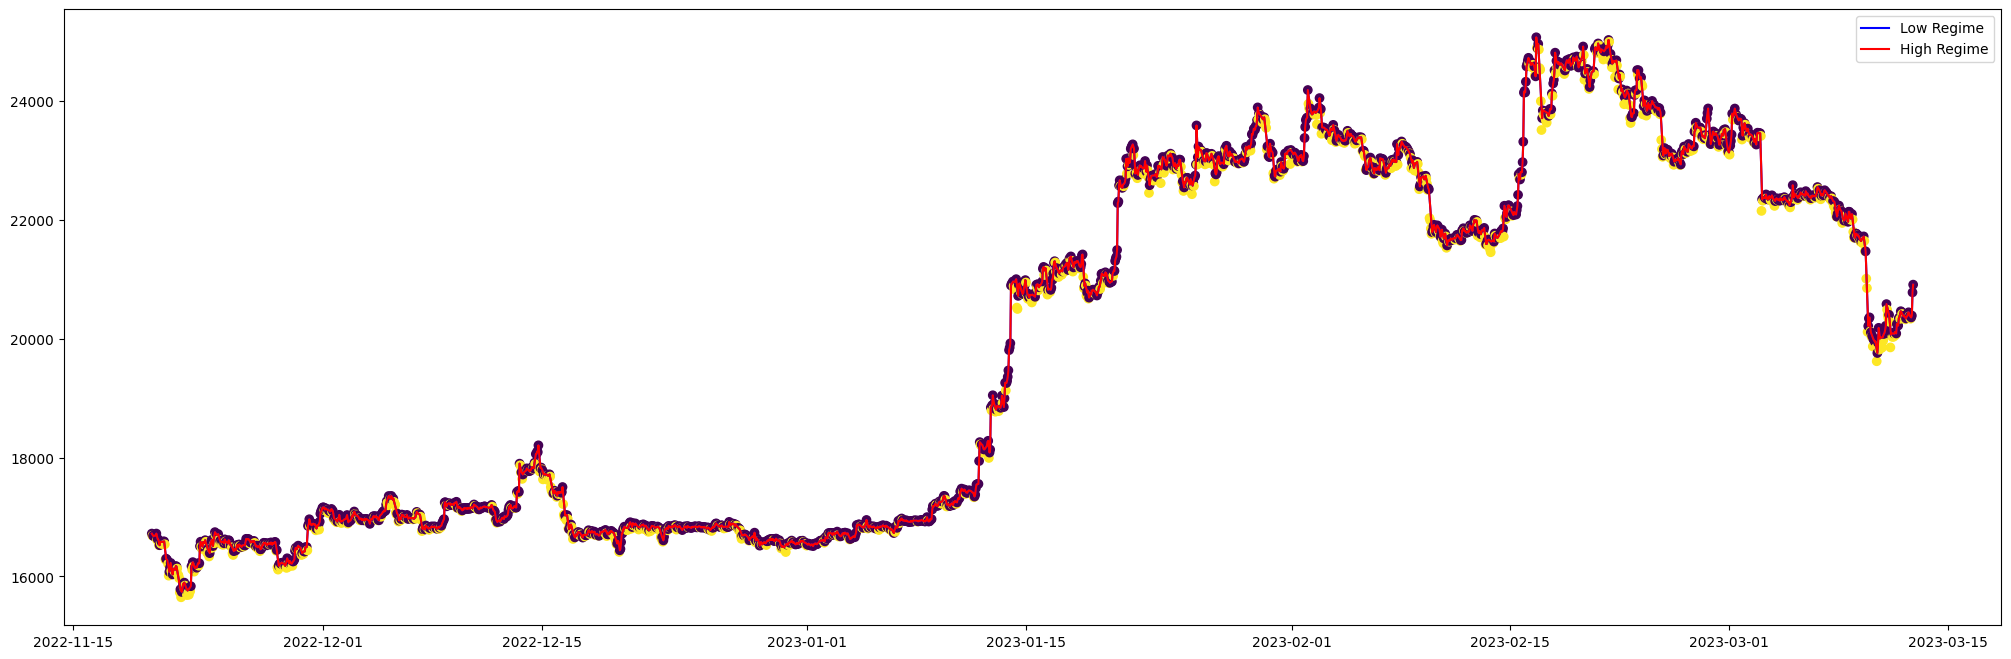

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 8))

plt.plot(
    df_BTC.loc[df_BTC["Regime"] == 1].index,
    df_BTC.loc[df_BTC["Regime"] == 1]["Close"],
    c="blue",
    label="Low Regime",
)
plt.plot(
    df_BTC.loc[df_BTC["Regime"] == 1].index,
    df_BTC.loc[df_BTC["Regime"] == 1]["Close"],
    c="red",
    label="High Regime",
)
plt.scatter(
    df_BTC.index,
    df_BTC["Close"],
    c=df_BTC.Regime.values,
)
plt.legend()

# With HMM Learn

<Axes: >

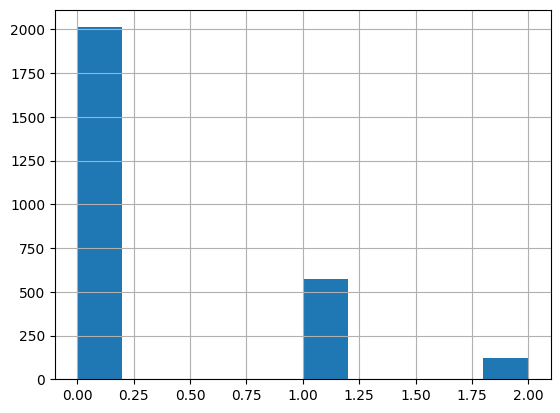

In [46]:
data = df_BTC[['Returns','Volume']]
if data.shape[-1] == 1:
    data = np.array(data).reshape(-1, 1) 

model = hmm.GaussianHMM(n_components=3 ,covariance_type='full')
model.fit(data)
model.score(data)

states = model.predict(data)

pd.Series(states).hist()

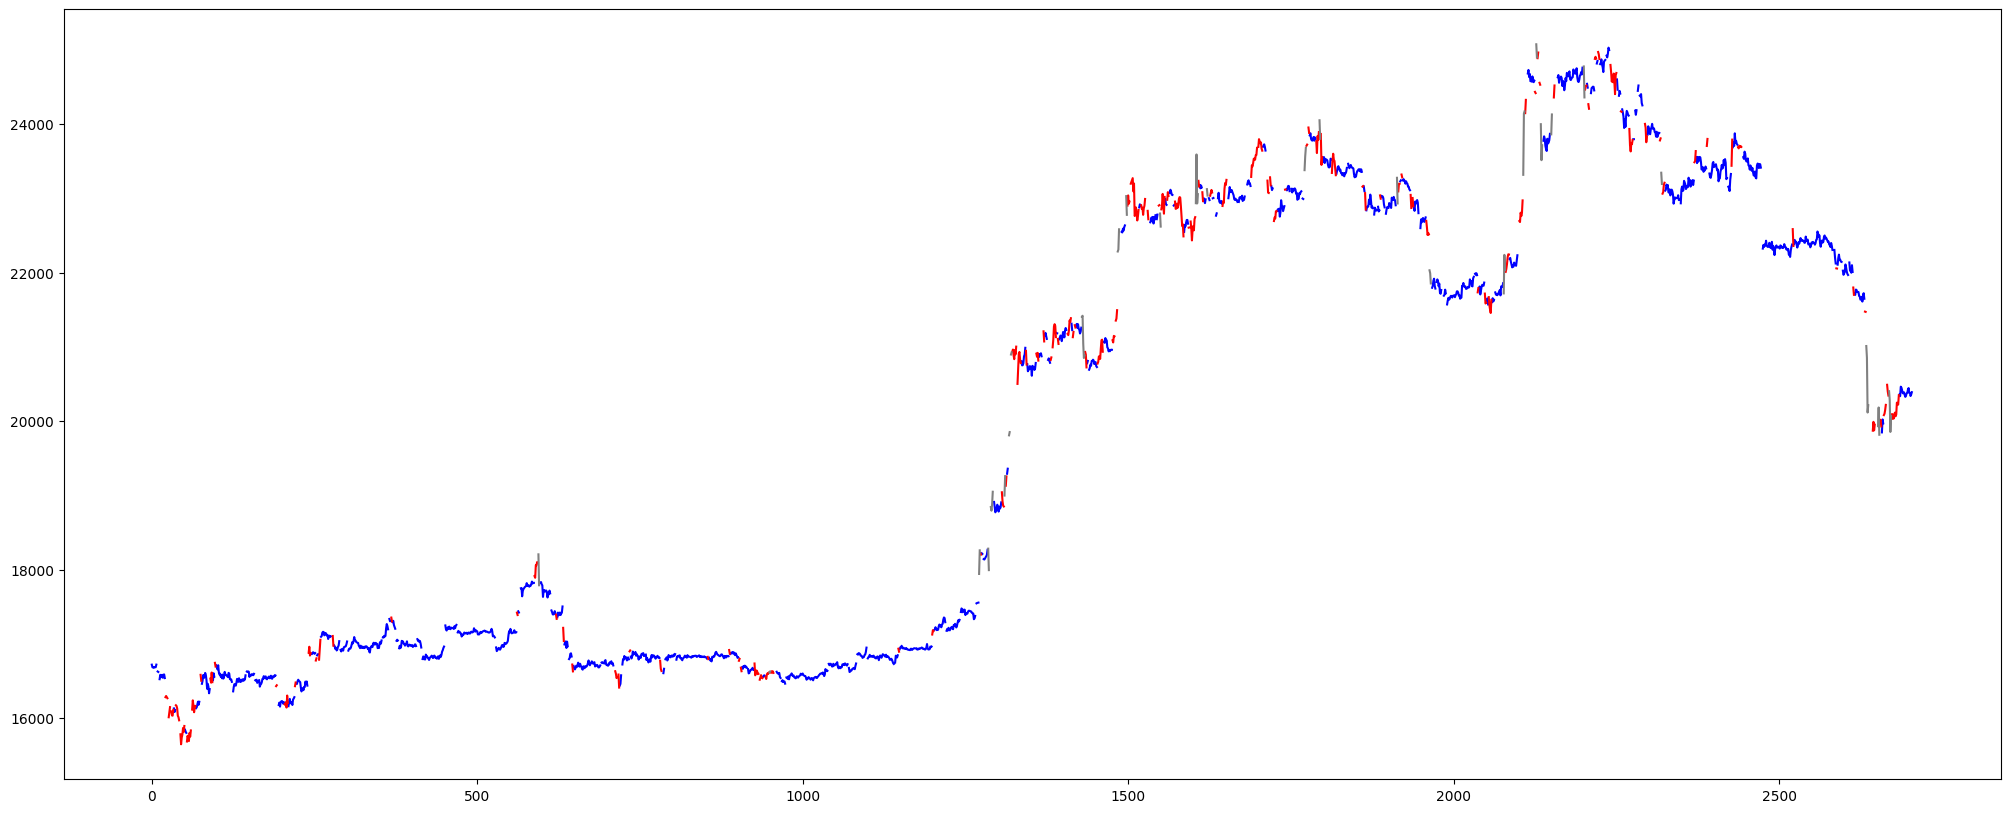

In [47]:
import matplotlib.pyplot as plt 
#state1,state2 = [],[]
state1,state2,state3 = [],[],[]
i = 0
for state in states:
  if state == 0:
    state1.append(df_BTC['Close'][i])
    state2.append(float('nan'))
    state3.append(float('nan'))
  if state == 1:
    state2.append(df_BTC['Close'][i])
    state1.append(float('nan'))
    state3.append(float('nan'))
  if state == 2:
    state3.append(df_BTC['Close'][i])
    state2.append(float('nan'))
    state1.append(float('nan'))
  i += 1
plt.figure(figsize=(25,10))
plt.plot(state1,color='blue')
plt.plot(state2,color='red')
plt.plot(state3,color='gray')